In [323]:
import os
from database.milvus_cloud_db.zilliz_retriever import semantic_search, initialize_retriever
from database.milvus_cloud_db.zilliz_retriever_b import initialize_retriever_b, semantic_search_b
from services.crud  import create_mental_health_db# database
from services.calculator_node import MentalHealthCalculator


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.agents import Tool
from langchain.tools import StructuredTool

from llm_model.llm import llm_model

from typing import TypedDict, Optional, List, Dict, Any, Union
from pydantic import BaseModel, Field, model_validator
import random
import json
from pyppeteer import launch
import asyncio
from tavily import TavilyClient
from bson import ObjectId 

In [324]:
# Initialize retriever
init_result = initialize_retriever(
    zilliz_uri="https://in03-d9c913fef2464e7.serverless.aws-eu-central-1.cloud.zilliz.com",
    zilliz_token="db_d9c913fef2464e7:Sh9&pO+<)v{>{0]1",
    collection_name= "mental_health_emori",
    embedding_model= "all-MiniLM-L6-v2",
    use_cuda= False
)
print(init_result)

Retriever initialized successfully


In [325]:
# Initialize retriever b
nit_result = initialize_retriever_b(
    zilliz_uri="https://in03-d9c913fef2464e7.serverless.aws-eu-central-1.cloud.zilliz.com",
    zilliz_token="db_d9c913fef2464e7:Sh9&pO+<)v{>{0]1",
    collection_name="sentiment_collection",
    embedding_model="all-MiniLM-L6-v2",
    use_cuda=False
)
print(init_result)


Retriever initialized successfully


In [326]:
# user = db.create_user("Alice Johnson")
# user_id = user["_id"]
# print(f"Created user with ObjectId: {user_id}")

In [327]:
# user_data = db.get_user(user_id)
# print(f"User name: {user_data['name']}")

In [ ]:
class MainState(TypedDict):
    user_query: str
    answer: str
    user_id: Optional[str] 
    
    # PATH A 
    semantic_search_a_results: Optional[List[Dict[str, str]]]
    graded_documents: Optional[List[Dict[str, Union[str, int]]]] 
    
    rewritten_query: Optional[str]
    internet_search_results: Optional[List[Dict[str, str]]]  
    counter: int
    
    
    # PATH B 
    semantic_search_b_results: Optional[List[Dict[str, Union[str, float]]]]  
    intensity_score: Optional[Dict[str, Any]]  # Changed to Any for context fields
    top_k_results: Optional[List[Dict[str, Union[str, float]]]]  
    
    # PATH C - Calculator fields
    user_scores: Optional[Dict[str, float]]  
    user_decay_scores: Optional[Dict[str, float]]  
    last_update_timestamp: Optional[str]  
    calc_result: Optional[float]
    
   
    
    evaluation_result: Optional[int] 
    
    warning_text: Optional[str] 
    evaluation_result: Optional[str]
    evaluation_feedback: Optional[str]
    memory: Optional[Dict[str, Any]]
    final_memory: Optional[Dict[str, Any]]

grading schema

In [329]:
class GradingDocument(BaseModel):
    grades: List[Dict[str, Union[str, int]]] = Field(
        description="List of documents with their grades", 
        example=[{"id": "doc1", "grade": 85}, {"id": "doc2", "grade": 92}]
    )

In [330]:
class SentimentScore(BaseModel):
    pos: float = Field(description="Positive sentiment score", ge=0.0, le=1.0)
    neg: float = Field(description="Negative sentiment score", ge=0.0, le=1.0) 
    neu: float = Field(description="Neutral sentiment score", ge=0.0, le=1.0)
    context_type: str = Field(description="Context type: personal, general, question, academic")
    personal_relevance: float = Field(description="How personally relevant (0.0-1.0)", ge=0.0, le=1.0)

top_k filter schema based user query

In [331]:
class FilteredResult(BaseModel):
    id: str = Field(description="Document ID")
    similarity_score: float = Field(description="Similarity score", ge=0.0, le=1.0)
    label: str = Field(description="Status/label of the document")
    text: str = Field(description="Text content of the document")

In [332]:
class FilteredResultsWrapper(BaseModel):
    results: List[FilteredResult] = Field(description="List of filtered relevant results")

In [333]:
class EvaluationResponse(BaseModel):
    score: int = Field(description="Evaluation score from 0-100", ge=0, le=100)
    feedback: str = Field(description="Brief feedback for improvement (max 300 words)")

tools

In [334]:
# tavily_client = TavilyClient(api_key="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")
# response = tavily_client.search(query="howa can we provide awareness about mental health to the youth", max_results=2)
# print(response)

In [335]:
# #tavily
# tavily_client = TavilyClient(api_key="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")


# def search_tavily(text: str):
#     response = tavily_client.search(query=text, max_results=2)
#     return response

# tool_tavily = Tool(
#         name="web_search",
#         func=search_tavily,
#         description="useful for when you want to search the web for information"
#     )

In [336]:
# tools = [tool_tavily]

# llm_with_tools = llm_model.bind_tools(tools)

Load Memory

In [337]:
def load_memory(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Load user's mental health data from MongoDB database.
    Returns existing data if user exists, empty values if new user.
    Includes comprehensive error handling for database failures.
    """
    user_id = state.get("user_id")
    
    try:
        # Use context manager for proper connection handling
        with create_mental_health_db("mongodb://host.docker.internal:27017/") as db:
            # Convert string to ObjectId if needed
            if isinstance(user_id, str):
                user_id = ObjectId(user_id)
            
            # Try to load existing user data
            user = db.get_user(user_id)
            
            if user:
                # Existing user - try to load their data
                print(f"Memory loaded for user: {user_id}")
                
                try:
                    # Load user scores with error handling
                    user_scores = None
                    try:
                        user_scores = db.get_user_scores(user_id)
                    except Exception as score_error:
                        print(f"Failed to load user scores: {score_error}")
                    
                    # Load decay scores with error handling
                    user_decay_scores = None
                    try:
                        user_decay_scores = db.get_decay_scores(user_id)
                    except Exception as decay_error:
                        print(f"Failed to load decay scores: {decay_error}")
                    
                    # Load conversation history with error handling
                    past_conversation = []
                    try:
                        past_conversation = db.get_conversation_history(user_id)
                    except Exception as conv_error:
                        print(f"Failed to load conversation history: {conv_error}")
                    
                    return {
                        "user_scores": user_scores,
                        "user_decay_scores": user_decay_scores,
                        "last_update_timestamp": user.get("last_update_timestamp"),
                        "memory": {
                            "past_conversation": past_conversation,
                            "name": user.get("name"),
                            "calc_result": user.get("calc_result")
                        }
                    }
                    
                except Exception as data_error:
                    print(f"Error loading user data for {user_id}: {data_error}")
                    # Return partial data - at least we know user exists
                    return {
                        "user_scores": None,
                        "user_decay_scores": None,
                        "last_update_timestamp": None,
                        "memory": {"name": user.get("name", "")}
                    }
            else:
                # New user - return empty values
                print(f"New user detected: {user_id}")
                return {
                    "user_scores": None,
                    "user_decay_scores": None,
                    "last_update_timestamp": None,
                    "memory": {}
                }
                
    except Exception as e:
        # Database connection failed - return defaults so system continues
        print(f"Database load failed for user {user_id}: {e}")
        return {
            "user_scores": None,
            "user_decay_scores": None,
            "last_update_timestamp": None,
            "memory": {}
        }

SEMANTIC SEARCH

In [338]:
# result = semantic_search(query, top_k=2, filters={"category": [] }, threshold=0.0)
# result_clean = [{'id': item['id'], 'text': item['text']} for item in result]
# result_clean

In [339]:
# def semantic_search_a(state: MainState) -> MainState:
#     try:
#         query = state["user_query"]
#         filter_value = state.get("filtered_results", "")
        
#         # Handle empty filter case
#         filters = {"category": [filter_value]} if filter_value else {}
        
#         semantic_result = semantic_search(query, top_k=10, filters=filters, threshold=0.0)
#         result = [{'id': item['id'], 'text': item['text']} for item in semantic_result]
        
#         if not result:
#             print(f"No semantic search results for query: {query}")
            
#         return {"semantic_search_a_results": result}
#     except Exception as e:
#         print(f"Semantic search A failed: {e}")
#         return {"semantic_search_a_results": []}

def semantic_search_a(state: MainState) -> MainState:
    query = state["user_query"]
    filter_value = state.get("filtered_results", "")
    current_counter = state.get("counter", 0)
    
    print(f"DEBUG SEARCH A: Query='{query}', Filter='{filter_value}', Counter={current_counter}")
    
    try:
        filters = {"category": [filter_value]} if filter_value else {}
        semantic_result = semantic_search(query, top_k=10, filters=filters, threshold=0.0)
        result = [{'id': item['id'], 'text': item['text']} for item in semantic_result]
        
        print(f"DEBUG SEARCH A: Found {len(result)} results")
        return {"semantic_search_a_results": result}
        
    except Exception as e:
        print(f"DEBUG SEARCH A: Error - {e}")
        return {"semantic_search_a_results": []}

In [340]:
# query = "i think i am depressed"
# result = semantic_search_b(query, top_k=2)
# result

In [ ]:
def semantic_search_b(state: MainState) -> MainState:
    try:
        query = state["user_query"]
        search_results = semantic_search_b(query, top_k=7)
        
        result = [{
            'id': item['id'],
            'similarity_score': item['similarity_score'],
            'text': item['text'],
            'status': item['status']
        } for item in search_results]
        
        if not result:
            print(f"No semantic search B results for query: {query}")
            
        return {"semantic_search_b_results": result}
    except Exception as e:
        print(f"Semantic search B failed: {e}")
        return {"semantic_search_b_results": []}

INTENSITY SCORE

In [342]:
def intensity_score(state: MainState) -> MainState:
    user_query = state["user_query"]
    prompt = (
        "You are an expert sentiment analyst. Analyze the sentiment AND context of the given text.\n"
        "Provide sentiment scores for positive, negative, and neutral that sum to exactly 1.0.\n"
        "Also determine:\n"
        "1. Context type: 'personal' (about user's feelings/experiences), 'general' (discussing others/topics), 'question' (asking for info), 'academic' (educational/research)\n"
        "2. Personal relevance: 0.0 = completely impersonal, 1.0 = deeply personal\n\n"
        f"Text to analyze: {user_query}\n\n"
        "Examples:\n"
        "- 'I feel depressed' → personal, relevance: 1.0\n"
        "- 'What is depression?' → question, relevance: 0.1\n"
        "- 'My friend is sad' → general, relevance: 0.3\n"
        "- 'Depression statistics' → academic, relevance: 0.0\n"
    )

    llm_response = llm_model.with_structured_output(SentimentScore).invoke(prompt)

    sentiment_scores = {
        'pos': llm_response.pos,
        'neg': llm_response.neg, 
        'neu': llm_response.neu,
        'context_type': llm_response.context_type,
        'personal_relevance': llm_response.personal_relevance
    }
    
    return {"intensity_score": sentiment_scores}

TOP K FILTER

In [343]:
def top_k_filter(state: MainState) -> MainState:
    user_query = state["user_query"]
    search_results = state.get("semantic_search_b_results", [])
    
    # If no search results, return empty
    if not search_results:
        return {"top_k_results": []}
    
    # Build improved prompt for LLM evaluation
    prompt = (
        "You are an expert mental health content curator. Your task is to filter search results based on semantic relevance to the user's query.\n\n"
        "INSTRUCTIONS:\n"
        "1. Analyze the user's query to understand the core emotions, conditions, or mental health topics they're expressing\n"
        "2. For each search result, evaluate if the STATUS and TEXT content genuinely relates to the user's mental state/query\n"
        "3. Keep results where there's a meaningful connection between the user's query and the document's content\n"
        "4. REMOVE results that are:\n"
        "   - Off-topic or unrelated to the user's mental health concern\n"
        "   - Generic content that doesn't match the specific emotional context\n"
        "   - False positives (high similarity but irrelevant meaning)\n\n"
        "QUALITY OVER QUANTITY: It's better to return fewer highly relevant results than many loosely related ones.\n\n"
        f"USER QUERY: {user_query}\n\n"
        "SEARCH RESULTS TO EVALUATE:\n"
    )
    
    # Add each search result to the prompt with better formatting
    for i, result in enumerate(search_results, 1):
        prompt += (
            f"RESULT {i}:\n"
            f"├─ ID: {result['id']}\n"
            f"├─ Original Similarity: {result['similarity_score']:.3f}\n"
            f"├─ Status/Label: {result['status']}\n"
            f"└─ Content: {result['text']}\n\n"
        )
    
    prompt += (
        "DECISION CRITERIA:\n"
        "- Does the status/label directly relate to the user's emotional state?\n"
        "- Does the content meaningfully address the user's concern?\n"
        "- Would this result be genuinely helpful for someone in this mental state?\n\n"
        "Return only the truly relevant results with ID, similarity score, label (status), and text content."
    )
    
    # Use structured output with schema
    llm_response = llm_model.with_structured_output(FilteredResultsWrapper).invoke(prompt)
    
    # Convert to list of dictionaries
    filtered_results = [
        {
            "id": result.id,
            "similarity_score": result.similarity_score,
            "label": result.label,
            "text": result.text
        }
        for result in llm_response.results
    ]
    
    return {"top_k_results": filtered_results}

GRADING DOCUMENT

In [344]:
def grading_document(state: MainState) -> MainState:
    query = state["user_query"]
    documents = state.get("semantic_search_a_results", [])
    
    if not documents:
        return {"graded_documents": []}
    
    # Include document IDs in the prompt
    prompt = f"""Rate each document's relevance to this query from 1-100:
Query: {query}

Documents:
"""
    
    for i, doc in enumerate(documents, 1):
        prompt += f"Document ID: {doc['id']}\nText: {doc['text'][:200]}...\n\n"
    
    prompt += f"""
Respond with JSON format containing exactly {len(documents)} grades:
{{"grades": [{{"id": "document_id_here", "grade": 75}}, {{"id": "another_document_id", "grade": 82}}]}}
"""
    
    try:
        llm_response = llm_model.with_structured_output(
            GradingDocument, 
            method="function_calling"
        ).invoke(prompt)
        
        graded_docs = llm_response.grades 
        grade_map = {str(doc['id']): int(doc['grade']) for doc in graded_docs}
        print(f"DEBUG GRADING: Success! Grade map: {grade_map}")
        
    except Exception as e:
        print(f"DEBUG GRADING: LLM failed, using defaults - {e}")
        grade_map = {}
        for i, doc in enumerate(documents):
            default_grade = 70 if i % 2 == 0 else 65
            grade_map[str(doc['id'])] = default_grade
    
    final_documents = []
    for doc in documents:
        doc_id = str(doc['id'])
        grade = grade_map.get(doc_id, 65)
        final_documents.append({
            "id": doc_id,
            "text": doc["text"],
            "grade": grade
        })
        
    print(f"DEBUG GRADING: Final document grades: {[d['grade'] for d in final_documents]}")
    return {"graded_documents": final_documents}

In [345]:
def merge_paths(state: MainState) -> MainState:
    """Simple merge to synchronize parallel paths"""
    return state


RETRY COUNTER
- we retry based on grade value 50< then retry, 50> then pass

In [346]:
# def retry_counter(state: MainState) -> MainState:
#     graded_documents = state.get("graded_documents", [])
#     current_counter = state.get("counter", 0)
    
    
#     # If no documents, increment counter = 1 means retry and add filter
#     if not graded_documents:
#         return {
#             "counter": current_counter + 1,
#         }
        
#     # Calculate average grade of all documents
#     total_grade = sum(doc.get("grade", 0) for doc in graded_documents) # extract grade from each document and sum them up
#     average_grade = total_grade / len(graded_documents)
    
#      # If average grade >= 50, keep counter unchanged
#     if average_grade >= 50:
#         return {"counter": current_counter}
    
#     # If average grade < 50, =  1 means retry and add filter
#     else:
#         return {"counter": current_counter + 1}    
    
def retry_counter(state: MainState) -> MainState:
    graded_documents = state.get("graded_documents", [])
    current_counter = state.get("counter", 0)
    
    print(f"DEBUG: Current counter: {current_counter}")
    print(f"DEBUG: Number of graded documents: {len(graded_documents)}")
    
    # If no documents, increment counter
    if not graded_documents:
        new_counter = current_counter + 1
        print(f"DEBUG: No documents, incrementing counter to: {new_counter}")
        return {"counter": new_counter}
        
    # Calculate average grade of all documents
    total_grade = sum(doc.get("grade", 0) for doc in graded_documents)
    average_grade = total_grade / len(graded_documents) if graded_documents else 0
    
    print(f"DEBUG: Average grade: {average_grade}")
    
    # If average grade >= 50, keep counter unchanged
    if average_grade >= 50:
        print(f"DEBUG: Good grade, keeping counter at: {current_counter}")
        return {"counter": current_counter}
    
    # If average grade < 50, increment counter
    else:
        new_counter = current_counter + 1
        print(f"DEBUG: Poor grade, incrementing counter to: {new_counter}")
        return {"counter": new_counter}  
    
    
    

In [347]:
# def check_retry_counter_routing(state: MainState) -> str:
#     retry_count = state.get("counter", 0)
#     limit_retry = 3  
    
#     if retry_count >= limit_retry:
#         return "answer_generator" 
    
#     # Normal retry logic
#     if retry_count == 0:
#         return "answer_generator"
#     elif retry_count == 1:
#         return "filter_generator" 
#     elif retry_count >= 2:
#         return "rewrite_query"
    
#     return "answer_generator"

def check_retry_counter_routing(state: MainState) -> str:
    retry_count = state.get("counter", 0)
    limit_retry = 3
    
    print(f"DEBUG ROUTING: retry_count={retry_count}, limit={limit_retry}")
    
    # Force answer generation if limit exceeded
    if retry_count >= limit_retry:
        print(f"DEBUG ROUTING: Limit reached, routing to answer_generator")
        return "answer_generator"
    
    # Normal retry logic
    if retry_count == 0:
        print(f"DEBUG ROUTING: First try, routing to answer_generator")
        return "answer_generator"
    elif retry_count == 1:
        print(f"DEBUG ROUTING: Second try, routing to filter_generator")
        return "filter_generator"
    elif retry_count >= 2:
        print(f"DEBUG ROUTING: Third try, routing to rewrite_query")
        return "rewrite_query"
    
    return "answer_generator"

CALCULATOR FUNCTION

In [348]:
# Initialize calculator (done once globally)
calculator = MentalHealthCalculator()

In [349]:
def calculator_func(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    LangGraph node for calculating mental health scores with context awareness.
    
    Clean, simple wrapper around the MentalHealthCalculator module.
    """
    # Extract inputs from state
    user_id = state.get("user_id", "default_user")
    top_k_results = state.get("top_k_results", [])
    
    # Get intensity score with context information
    intensity_score = state.get("intensity_score", {
        "pos": 0.33, "neg": 0.33, "neu": 0.34,
        "context_type": "personal", "personal_relevance": 1.0
    })
    
    # Get existing user data
    current_scores = state.get("user_scores")
    decay_scores = state.get("user_decay_scores") 
    last_update = state.get("last_update_timestamp")
    
    # Calculate updated scores
    updated_scores, updated_decay, timestamp, calc_result = calculator.calculate_scores(
        user_id=user_id,
        top_k_results=top_k_results,
        intensity_score=intensity_score,
        current_scores=current_scores,
        decay_scores=decay_scores,
        last_update_timestamp=last_update
    )
    
    # Return updated state
    return {
        "user_scores": updated_scores,
        "user_decay_scores": updated_decay,
        "last_update_timestamp": timestamp,
        "calc_result": calc_result
    }

In [350]:
def merge_calculator_inputs(state: MainState) -> MainState:
    # Simple pass-through that ensures both paths complete
    return state

WARNING GEN FLAG

In [351]:
def warning_gen_flag(state: Dict[str, Any]) -> Dict[str, Any]:
    calc_result = state.get("calc_result", 0.0)
    user_scores = state.get("user_scores", {})
    
    # Simple threshold-based warning (50/100 = moderate concern)
    if calc_result >= 50.0:
        # Get concerning scores (excluding Normal, above 20/100)
        negative_scores = [
            (label, score) for label, score in user_scores.items() 
            if label != "Normal" and score > 20.0
        ]
        
        # Sort by highest scores and get top 2
        top_2 = sorted(negative_scores, key=lambda x: x[1], reverse=True)[:2]
        
        if len(top_2) >= 2:
            warning_text = f"Elevated indicators detected: {top_2[0][0]} ({top_2[0][1]:.1f}/100), {top_2[1][0]} ({top_2[1][1]:.1f}/100)"
        elif len(top_2) == 1:
            warning_text = f"Elevated indicators detected: {top_2[0][0]} ({top_2[0][1]:.1f}/100)"
        else:
            warning_text = "General concern detected"
            
    else:
        warning_text = ""
    
    return {"warning_text": warning_text}

FILTER GENERATOR

In [352]:
def filter_generator(state: MainState) -> MainState:
    query = state["user_query"]
    
    prompt = (
        "Based on the user query, analyze and choose exactly ONE category from this list:\n"
        "- research\n"
        "- report\n"  
        "- conversation\n"
        "- article\n\n"
        f"User query: {query}\n\n"
        "Respond with only ONE word from the list above. No explanations, no other text."
    )
    
    try:
        llm_response = llm_model.invoke(prompt)
        filter_word = llm_response.strip().lower()
        
        # Validate the response is one of the allowed categories
        allowed_categories = ["research", "report", "conversation", "article"]
        
        if filter_word in allowed_categories:
            return {"filtered_results": filter_word}
        else:
            # Invalid response, return empty to trigger retry
            return {"filtered_results": ""}
        
    except Exception:
        # LLM failed, return empty to trigger retry
        return {"filtered_results": ""}

In [353]:
def rewrite_query(state: MainState) -> MainState:
    user_query = state["user_query"]
    prompt = (
        "You are an expert at rewriting queries for internet search.\n"
        "Take the user's original query and rewrite it into a short, effective search query.\n"
        "Focus on the key concepts and use terms that would work well for web search.\n"
        "Keep it concise and specific.\n\n"
        f"Original query: {user_query}\n\n"
        "Rewrite this as a short search query:"
    )
    
    try:
        llm_response = llm_model.invoke(prompt)
        rewritten = llm_response.strip()
        
        # If LLM fails to rewrite, use original query as fallback
        if not rewritten:
            rewritten = user_query
            
        return {"rewritten_query": rewritten}
    
    # If LLM completely fails, use original query
    except Exception:
        return {"rewritten_query": user_query}


INTERNET SEARCH

In [354]:
tavily_client = TavilyClient(api_key="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")

In [355]:
def internet_search(state: MainState) -> MainState:
    try:
        rewritten_query = state.get("rewritten_query", state.get("user_query", ""))
        
        response = tavily_client.search(query=rewritten_query, max_results=2)
        results = response.get("results", [])
        
        extracted = []
        for item in results:
            title = item.get("title", "")
            content = item.get("content", "")
            if title or content:
                extracted.append({
                    "title": title,
                    "text": content
                })
                
        if not extracted:
            print(f"No internet search results for query: {rewritten_query}")
            
        return {"internet_search_results": extracted}
    except Exception as e:
        print(f"Internet search failed: {e}")
        return {"internet_search_results": []}

Merge Path from :
- PATH A: retry_counter → answer_generator (when counter=0)
- PATH B: warning_gen_flag → answer_generator
- Rewrite path: internet_search → answer_generator

In [356]:
def merge_paths(state: MainState) -> MainState:
 # we merge all paths to answer_generator
    return state

ANSWER GENERATOR

In [ ]:
from typing import Dict, Any

def answer_generator(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Generate mental health support response based on available documents and user context.
    Incorporates evaluation feedback for response improvement when available.
    """
    user_query = state.get("user_query", "")
    graded_documents = state.get("graded_documents", [])
    internet_search_results = state.get("internet_search_results", [])
    warning_text = state.get("warning_text", "")
    evaluation_feedback = state.get("evaluation_feedback", "")
    current_retries = state.get("answer_retry_count", 0)
    
    # Extract context from available sources
    context_sources = []
    
    # Priority 1: Graded documents (internal knowledge base)
    if graded_documents:
        for doc in graded_documents:
            context_sources.append(doc.get("text", ""))
    
    # Priority 2: Internet search results (if no graded documents)
    elif internet_search_results:
        for result in internet_search_results:
            title = result.get("title", "")
            text = result.get("text", "")
            combined_text = f"{title}. {text}".strip()
            if combined_text:
                context_sources.append(combined_text)
    
    # Handle case with no available sources
    if not context_sources:
        return {
            "answer": "I apologize, but I'm currently unable to access the information needed to provide you with a proper response. The developer is working on resolving this issue. In the meantime, if you're experiencing distress, please consider reaching out to a mental health professional or a crisis helpline for immediate support."
        }
    
    # Build context string for LLM
    context_text = "\n".join([f"- {source}" for source in context_sources])
    
    # Add feedback section if available
    feedback_section = ""
    if evaluation_feedback:
        feedback_section = f"\n\nPREVIOUS RESPONSE FEEDBACK (improve based on this):\n{evaluation_feedback}"
    
    # Construct mental health counselor prompt
    prompt = f"""You are Emori, a licensed mental health counselor with 15 years of experience specializing in anxiety, depression, and stress management. You provide compassionate, evidence-based support while maintaining professional boundaries.

USER QUERY: {user_query}

AVAILABLE CONTEXT INFORMATION:
{context_text}

MENTAL HEALTH ASSESSMENT: {warning_text if warning_text else "No specific concerns detected at this time"}{feedback_section}

RESPONSE GUIDELINES:
1. Address the user's query directly using the provided context information
2. Provide practical, actionable strategies based on the available resources
3. Use warm, empathetic language while maintaining professional boundaries
4. If mental health concerns are indicated, acknowledge them sensitively and provide appropriate guidance
5. Include relevant coping strategies, self-care techniques, or professional resources when appropriate
6. Validate the user's experience without making clinical diagnoses
7. Keep responses focused, helpful, and supportive
. If feedback is provided above, incorporate those improvements into your response

IMPORTANT BOUNDARIES:
- You are an AI providing supportive information, not a replacement for professional therapy
- Do not provide medical diagnoses or prescribe treatments
- If crisis indicators are present, emphasize the importance of immediate professional support
- answer cant be more than 300 words
- answer cant be more than 300 words

Please provide a thoughtful, supportive response that addresses the user's needs while incorporating the available information and any mental health considerations."""


    # Generate response using LLM
    try:
        llm_response = llm_model.invoke(prompt)
        answer = llm_response.strip()
    except Exception:
        # Fallback response if LLM fails
        answer = "I understand you're reaching out for support. While I'm experiencing some technical difficulties right now, I want you to know that your concerns are valid. If you're in immediate distress, please contact a mental health professional or crisis helpline. Otherwise, please try again in a few moments."
    
    return {
        "answer": answer,
        "answer_retry_count": current_retries + 1  # Increment for next iteration
    }

EVALUATOR

In [358]:
def evaluator(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Simple evaluator that scores response quality and provides improvement feedback.
    """
    user_query = state.get("user_query", "")
    answer = state.get("answer", "")
    current_retries = state.get("answer_retry_count", 0)
    
    prompt = f"""You are an evaluator for mental health AI responses. Your job is to assess response quality and provide improvement feedback.

EVALUATION RULES:
- Score 0-100 based on how well the response addresses the user's mental health needs
- Deduct points for: harmful advice, medical diagnoses, inappropriate tone, irrelevant content
- Award points for: empathy, helpfulness, professional boundaries, safety awareness
- Provide brief feedback (under 300 words) on how to improve the response

USER QUERY: {user_query}

AI RESPONSE TO EVALUATE: {answer}

SCORING GUIDELINES:
90-100: Excellent - empathetic, helpful, safe, directly addresses query
70-89: Good - mostly helpful with minor issues
50-69: Average - basic response but has notable problems  
30-49: Poor - significant issues, not very helpful
0-29: Very poor - harmful, irrelevant, or inappropriate

Evaluate the response and provide your score with brief improvement feedback."""

    try:
        llm_response = llm_model.with_structured_output(
            EvaluationResponse, 
            method="function_calling"
        ).invoke(prompt)
        
        feedback = llm_response.feedback if llm_response.score <= 70 else ""
        
        return {
            "evaluation_result": llm_response.score,
            "evaluation_feedback": feedback,
            "answer_retry_count": current_retries  # Don't increment here
        }
    except Exception:
        return {
            "evaluation_result": 70,
            "evaluation_feedback": "",
            "answer_retry_count": current_retries
        }
    

SAVE MEMORY

In [359]:
def save_memory(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Save user data to MongoDB database using ObjectId as primary key.
    Appends conversation to past_conversation and overwrites mental health data.
    Includes comprehensive error handling for database failures.
    """
    user_id = state.get("user_id")
    user_query = state.get("user_query", "")
    answer = state.get("answer", "")
    
    try:
        # Use context manager for proper connection handling
        with create_mental_health_db("mongodb://host.docker.internal:27017/") as db:
            # Convert string to ObjectId if needed
            if isinstance(user_id, str):
                user_id = ObjectId(user_id)
            
            # Check if user exists first
            user = db.get_user(user_id)
            if not user:
                print(f"Warning: User not found: {user_id}")
                return {"final_memory": {
                    "conversation_saved": False,
                    "metrics_saved": False,
                    "status": "user_not_found",
                    "error": f"User {user_id} does not exist"
                }}
            
            # Try to append conversation
            conversation_saved = False
            try:
                conversation_saved = db.append_conversation(user_id, user_query, answer)
                if conversation_saved:
                    print(f"Conversation saved for user: {user_id}")
                else:
                    print(f"Failed to save conversation for user: {user_id}")
            except Exception as conv_error:
                print(f"Conversation save error for user {user_id}: {conv_error}")
            
            # Prepare bulk update data for mental health metrics
            update_data = {}
            
            if state.get("user_scores") is not None:
                update_data["user_scores"] = state.get("user_scores")
            
            if state.get("user_decay_scores") is not None:
                update_data["user_decay_scores"] = state.get("user_decay_scores")
            
            if state.get("last_update_timestamp") is not None:
                update_data["last_update_timestamp"] = state.get("last_update_timestamp")
            
            if state.get("calc_result") is not None:
                update_data["calc_result"] = state.get("calc_result")
            
            # Try to bulk update mental health data
            metrics_saved = False
            if update_data:
                try:
                    metrics_saved = db.bulk_update_user(user_id, update_data)
                    if metrics_saved:
                        print(f"Mental health metrics saved for user: {user_id}")
                    else:
                        print(f"Failed to save metrics for user: {user_id}")
                except Exception as metrics_error:
                    print(f"Metrics save error for user {user_id}: {metrics_error}")
            
            # Return success status with details
            print(f"Memory save completed for user: {user_id}")
            return {"final_memory": {
                "conversation_saved": conversation_saved,
                "metrics_saved": metrics_saved,
                "updated_fields": list(update_data.keys()),
                "status": "success"
            }}
            
    except Exception as e:
        # Database connection or general error
        print(f"Database save failed for user {user_id}: {e}")
        return {"final_memory": {
            "conversation_saved": False,
            "metrics_saved": False,
            "status": "database_error",
            "error": str(e)
        }}

### CONIDITION ROUTING

SHOULD RETRY ANSWER

In [360]:
    
# def should_retry_answer(state: MainState) -> str:
#     score = state.get("evaluation_result", 50)
#     answer_retry_count = state.get("answer_retry_count", 0)
    
#     print(f"DEBUG EVALUATOR: Score={score}, Answer retries={answer_retry_count}")
    
#     if score < 70 and answer_retry_count < 2:
#         print(f"DEBUG EVALUATOR: Retrying - attempt {answer_retry_count + 1}")
#         # The increment happens in the state update when returning to answer_generator
#         return "answer_generator"
    
#     print(f"DEBUG EVALUATOR: Stopping retries")
#     return "__end__"


def should_retry_answer(state: MainState) -> str:
    """No retries - proceed directly to save"""
    return "__end__"

SHOULD USE INTERNET SEARCH

CHECK NO TRY OK

COMPILE

In [361]:
# Update your workflow:
workflow = StateGraph(MainState)

# Add nodes (including merge_paths)
workflow.add_node("load_memory", load_memory)
workflow.add_node("semantic_search_a", semantic_search_a)
workflow.add_node("semantic_search_b_node", semantic_search_b_node)
workflow.add_node("intensity_score", intensity_score)
workflow.add_node("grading_document", grading_document)
workflow.add_node("retry_counter", retry_counter)
workflow.add_node("top_k_filter", top_k_filter)
workflow.add_node("calculator_func", calculator_func)
workflow.add_node("warning_gen_flag", warning_gen_flag)
workflow.add_node("filter_generator", filter_generator)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("internet_search", internet_search)
workflow.add_node("merge_paths", merge_paths)  # Add this
workflow.add_node("answer_generator", answer_generator)
workflow.add_node("evaluator", evaluator)
workflow.add_node("save_memory", save_memory)

workflow.set_entry_point("load_memory")

# Split into two paths
workflow.add_edge("load_memory", "semantic_search_a")
workflow.add_edge("load_memory", "semantic_search_b_node")

# PATH A flow
workflow.add_edge("semantic_search_a", "grading_document")
workflow.add_edge("grading_document", "retry_counter")

workflow.add_conditional_edges(
    "retry_counter",
    check_retry_counter_routing,
    {
        "answer_generator": "merge_paths",  # Route to merge_paths instead
        "filter_generator": "filter_generator", 
        "rewrite_query": "rewrite_query"
    }
)

workflow.add_edge("filter_generator", "semantic_search_a")

# PATH B flow
workflow.add_edge("semantic_search_b_node", "intensity_score")
workflow.add_edge("semantic_search_b_node", "top_k_filter")
workflow.add_edge("intensity_score", "calculator_func")
workflow.add_edge("top_k_filter", "calculator_func")
workflow.add_edge("calculator_func", "warning_gen_flag")
workflow.add_edge("warning_gen_flag", "merge_paths")  # Route to merge_paths instead

# Rewrite query flow
workflow.add_edge("rewrite_query", "internet_search")
workflow.add_edge("internet_search", "merge_paths")  # Route to merge_paths instead

# Merge and continue
workflow.add_edge("merge_paths", "answer_generator")

# Rest stays the same
workflow.add_edge("answer_generator", "evaluator")
workflow.add_conditional_edges(
    "evaluator",
    should_retry_answer,
    {
        "answer_generator": "answer_generator",
        "__end__": "save_memory"
    }
)

workflow.add_edge("save_memory", END)
graph = workflow.compile()

In [362]:
graph = workflow.compile()

In [363]:
# from pyppeteer import launch
# import asyncio

# async def test_browser():
#     browser = await launch(
#         headless=True,
#         args=[
#             '--no-sandbox',
#             '--disable-setuid-sandbox',
#             '--disable-dev-shm-usage',
#             '--disable-gpu',
#             '--single-process',
#             '--no-zygote'
#         ]
#     )
#     print("Chromium launched successfully!")
#     await browser.close()

# await test_browser()


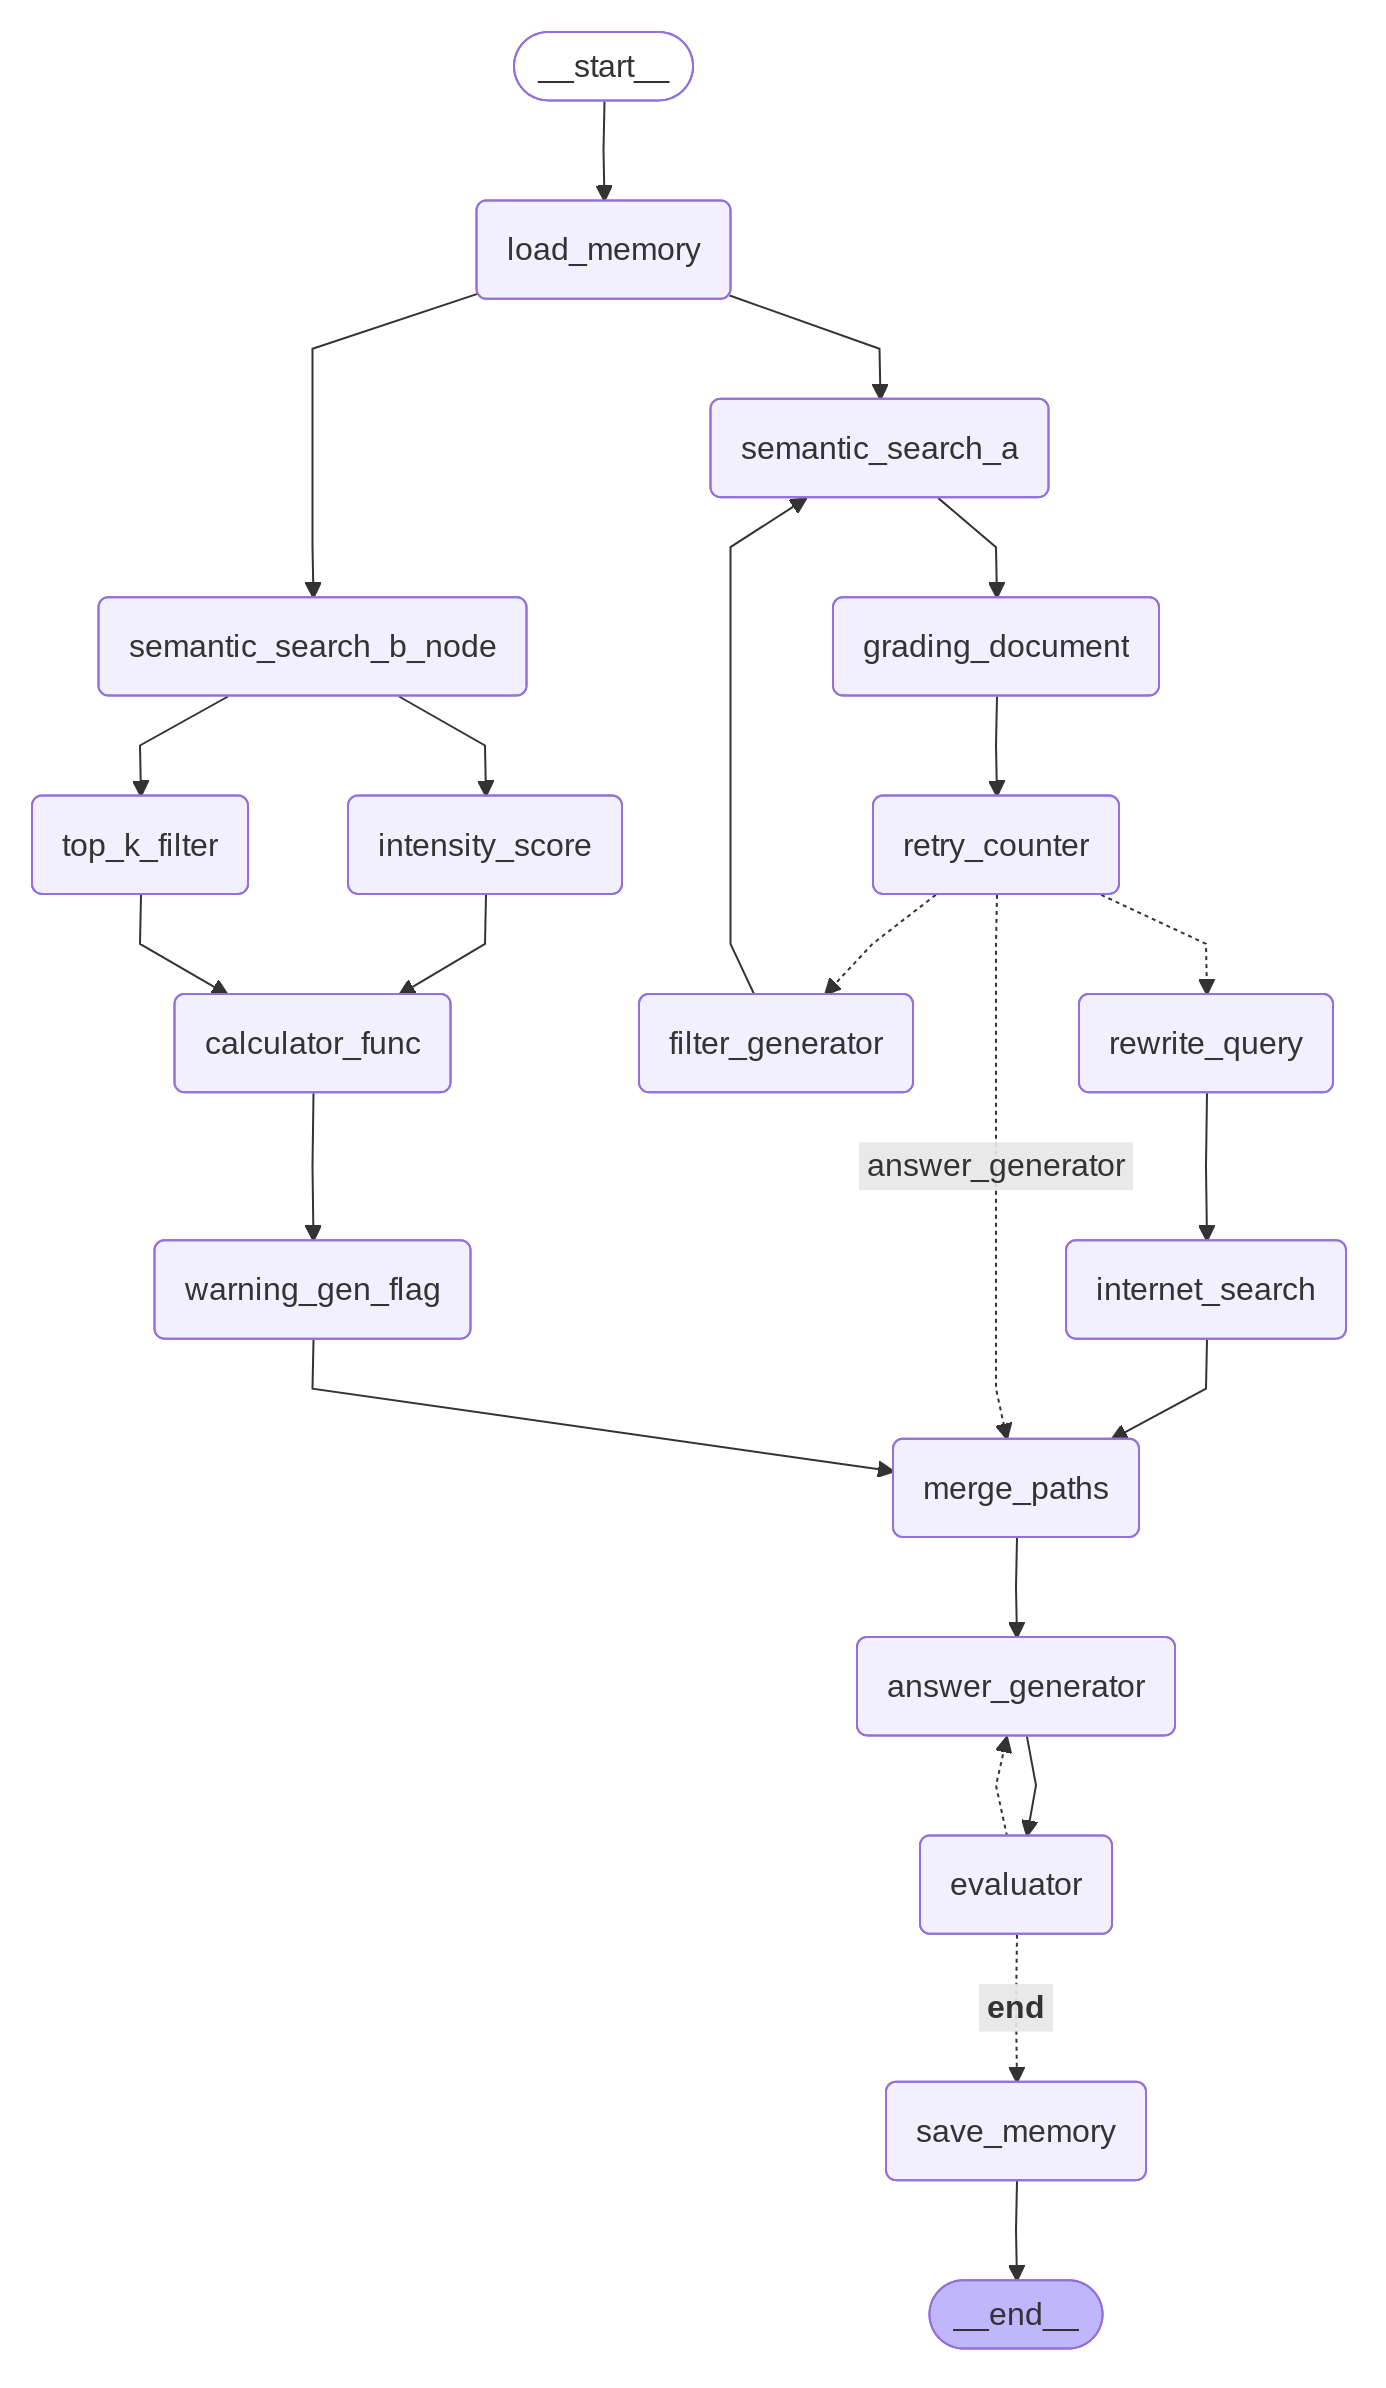

In [364]:
import asyncio
from pyppeteer import launch
from langchain_core.runnables.graph_mermaid import _render_mermaid_using_pyppeteer

# Monkey patch launch inside _render_mermaid_using_pyppeteer
original_launch = launch
async def launch_no_sandbox(*args, **kwargs):
    kwargs['args'] = kwargs.get('args', []) + [
        '--no-sandbox',
        '--disable-setuid-sandbox',
        '--disable-dev-shm-usage',
        '--disable-gpu',
        '--single-process',
        '--no-zygote'
    ]
    return await original_launch(*args, **kwargs)

import langchain_core.runnables.graph_mermaid as graph_mermaid
graph_mermaid.launch = launch_no_sandbox

# Render PNG
mermaid_code = graph.get_graph().draw_mermaid()
png_bytes = await _render_mermaid_using_pyppeteer(mermaid_code, device_scale_factor=2, padding=20)

# Save & display
with open("graph.png", "wb") as f:
    f.write(png_bytes)

from IPython.display import Image, display
display(Image(png_bytes))


In [365]:
# print(graph.get_graph().print_ascii())


In [366]:
def validate_inputs(user_id, user_query):
    """Validate user inputs before starting the system."""
    if not user_id or not str(user_id).strip():
        return False, "Error: user_id is required and cannot be empty", None
    
    if not user_query or not str(user_query).strip():
        return False, "Error: user_query is required and cannot be empty", None
    
    try:
        if isinstance(user_id, str):
            validated_user_id = ObjectId(user_id)
        else:
            validated_user_id = user_id
            
        with create_mental_health_db("mongodb://host.docker.internal:27017/") as db:
            user = db.get_user(validated_user_id)
            if not user:
                return False, f"Error: User with ID {user_id} not found in database", None
                
        return True, "Validation successful", validated_user_id
        
    except Exception as e:
        return False, f"Error: Invalid user_id format or database error - {str(e)}", None

In [367]:
def run_mental_health_system(user_id, user_query):
    """Run the complete mental health chat system with input validation."""
    print("Starting Mental Health Chat System...")
    print(f"Input - User ID: {user_id}")
    print(f"Input - Query: {user_query}")
    print("-" * 50)
    
    is_valid, message, validated_user_id = validate_inputs(user_id, user_query)
    
    if not is_valid:
        print(f"SYSTEM CANNOT START: {message}")
        return None
    
    print("Input validation passed")
    print(f"Validated User ID: {validated_user_id}")
    print("-" * 50)
    
    initial_state = {
        "user_id": str(validated_user_id),
        "user_query": user_query.strip(),
        "counter": 0
    }
    
    try:
        print("Executing LangGraph system...")
        # Set recursion limit in config
        config = {"recursion_limit": 25}
        result = graph.invoke(initial_state, config=config)
        
        print("System execution completed successfully")
        print(f"Final Answer: {result.get('answer', 'No answer generated')}")
        return result
        
    except Exception as e:
        print(f"System execution failed: {str(e)}")
        return None

In [368]:
user_id = "68d0ea8a54c5e7b82e722267"
user_query = "i want to die, I HATE MY FUCKING LIFEEEEEEEE I HATE IT I HATE EVERTHINGGGGGGGG I HATE IT I HATE IT SO FKING MUCH"

result = run_mental_health_system(user_id, user_query)

Starting Mental Health Chat System...
Input - User ID: 68d0ea8a54c5e7b82e722267
Input - Query: i want to die, I HATE MY FUCKING LIFEEEEEEEE I HATE IT I HATE EVERTHINGGGGGGGG I HATE IT I HATE IT SO FKING MUCH
--------------------------------------------------
Input validation passed
Validated User ID: 68d0ea8a54c5e7b82e722267
--------------------------------------------------
Executing LangGraph system...
Memory loaded for user: 68d0ea8a54c5e7b82e722267
DEBUG SEARCH A: Query='i want to die, I HATE MY FUCKING LIFEEEEEEEE I HATE IT I HATE EVERTHINGGGGGGGG I HATE IT I HATE IT SO FKING MUCH', Filter='', Counter=0
DEBUG SEARCH A: Found 10 results
DEBUG GRADING: LLM failed, using defaults - 1 validation error for GradingDocument
grades
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
DEBUG GRADING: Final document grades: [70, 65, 70, 65, 70, 65, 70, 65, 70, 65]
DEBUG: Current counter: 0
DEBUG: Number 